In [20]:
import numpy as np
from scipy import stats

# Keep from using the GPU if want to use very large simulated datasets
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import sys
sys.path.append("../src/")
import logistic_regression as lr

import imp 
imp.reload(lr)

<module 'logistic_regression' from '../src/logistic_regression.py'>

In [21]:
# Simulate parameter and data
beta = np.random.normal(size=2)
print("True beta: ", beta)

N, sigma_x = 10, 2.0
X, Y = lr.gen_data(N, beta, sigma_x)
X, Y = tf.convert_to_tensor(X), tf.convert_to_tensor(Y)

True beta:  [-0.86657055  0.34901227]


In [22]:
# Compute MLE
beta_MLE = lr.MLE(X, Y)
print("MLE:", beta_MLE, "Err = %0.03f"%np.linalg.norm(beta-beta_MLE))

# Compute MAP
beta_MAP = lr.MAP(X, Y)
print("MAP:", beta_MAP, "Err = %0.03f"%np.linalg.norm(beta-beta_MAP))

MLE: [-2.60624933 -3.30301082] Err = 4.045
MAP: [-0.79410162 -0.15097586] Err = 0.505


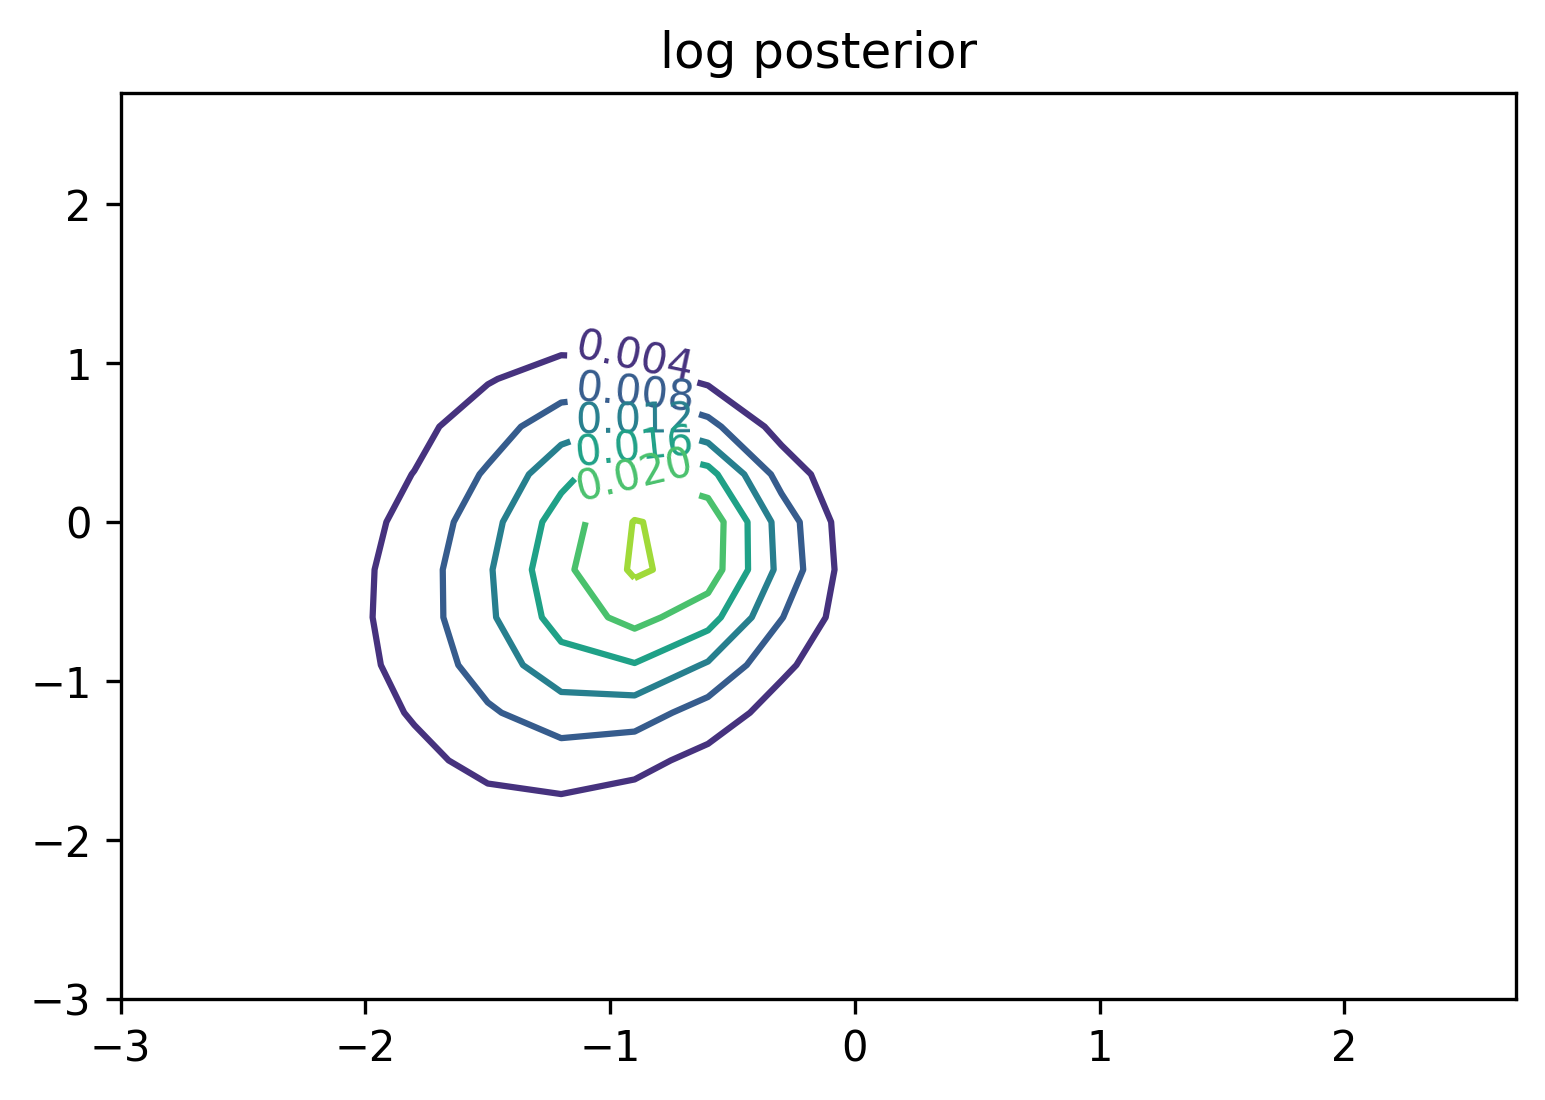

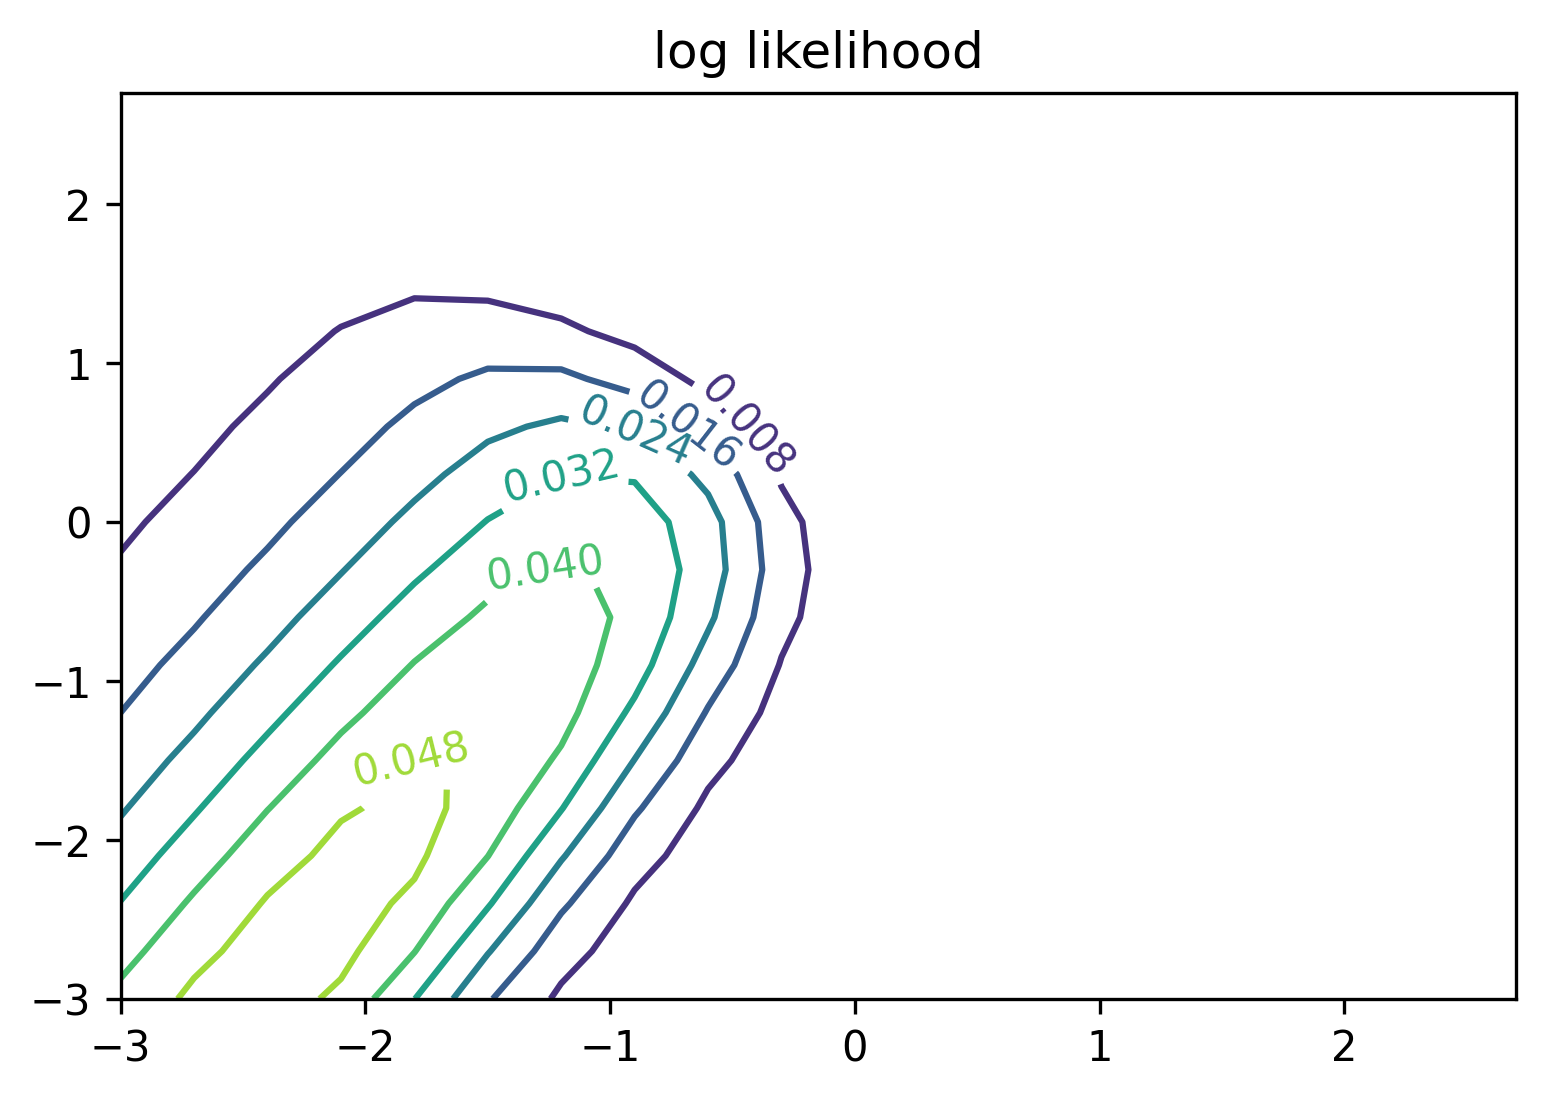

In [23]:
# Make contour plots
n_grid_spaces = 10
X_1, X_2, Z = lr.posterior_density_grid(X, Y, n_grid_spaces=n_grid_spaces)
lr.plot_density(X_1, X_2, np.exp(Z), title="log posterior")
Z = lr.lik_grid(X, Y, n_grid_spaces=n_grid_spaces)[2]
lr.plot_density(X_1, X_2, np.exp(Z), title="log likelihood")

# 2-D Gauss-Hermite Quadrature with Change of Variables

For $\gamma \in \mathbb{R}^2$, we approximate 
$$\int_{\mathbb{R}^2} e^{-\|\gamma\|^2} f(\gamma) d\gamma \approx \sum_{n}\sum_{n^\prime} 
w_n w_{n^\prime} f\left(\begin{bmatrix}x_n \\ x_{n^\prime} \end{bmatrix}\right).$$

If instead we have 
$$
g(\beta) = \text{exp}\{-\frac{1}{2}(\beta- \mu)^\top \Sigma^{-1} (\beta - \mu) \} f(\beta)
$$
and want to approximate 
$$\int_{\mathbb{R}^2} g(\beta) d\beta,$$
we can make a change of variables with $\gamma$ with $\beta = \phi(\gamma) := \sqrt{2}\Sigma^{\frac{1}{2}}\gamma + \mu$.

Then 
\begin{align}
\begin{split}
\int_{\mathbb{R}^2} g(\beta) d\beta &= \int_{\mathbb{R}^2} g(\phi(\gamma))
\left|\frac{\partial}{\partial \gamma} \phi(\gamma)\right| d\gamma\\
&= \left|\sqrt{2}\Sigma^{\frac{1}{2}}\right| \int \text{exp}\{- \|\gamma\|^2 \} f\left[\phi(\gamma)\right]d\gamma \\
&\approx \left|\sqrt{2}\Sigma^{\frac{1}{2}}\right| \sum_{n, n^\prime} w_n w_{n^\prime} f\left[\phi(
\begin{bmatrix}x_n \\ x_{n^\prime} \end{bmatrix}
)\right].
\end{split}
\end{align}


In our case, we have $g(\beta) = \text{exp}\{-\frac{1}{2}\|\beta\|^2 \} \prod p(y_n | x_n, \beta)$.  And can approximate it well, up to a constant of proportionality, by $h(\beta)=\text{exp}\{-\frac{1}{2} (\beta - \hat \beta)^\top (I + H)(\beta - \hat \beta) \}$, where $\hat \beta$ is the MAP, and $H$ is the Hessian of the log likelihood at $\hat \beta$.

We begin then by instead writing 
$$
g(\beta) = \text{exp}\{-\frac{1}{2}(\beta- \hat \beta)^\top (I + H)(\beta - \hat \beta)\} *
\left[\text{exp} \{ \frac{1}{2}(\beta- \hat \beta)^\top (I + H)(\beta - \hat \beta)\} g(\beta)\right]
$$

Changing variables to $\gamma$ such that $\beta = \phi(\gamma) := \sqrt{2}(I+H)^{-\frac{1}{2}} + \hat \beta$ we get 
$$
g(\phi(\gamma)) = \text{exp}\{-\|\gamma\|^2 \} * \left[
\text{exp}\{\|\gamma\|^2\} g(\phi(\gamma))
\right].
$$

And so 
\begin{split}
\int_{\mathbb{R}^2} g(\beta) d\beta &= \int_{\mathbb{R}^2} g(\phi(\gamma))
\left|\frac{\partial}{\partial \gamma} \phi(\gamma)\right| d\gamma\\
&= \left|\sqrt{2}(I + H)^{-\frac{1}{2}}\right| \int \text{exp}\{- \|\gamma\|^2 \} \left[
\text{exp}\{\|\gamma\|^2\} g(\phi(\gamma)\right]d\gamma \\
&\approx \left|\sqrt{2}(I + H)^{-\frac{1}{2}}\right| \sum_{n, n^\prime} w_n w_{n^\prime} \text{exp}\{x_n^2 + x_{n^\prime}^2\} g\left[\phi(
\begin{bmatrix}x_n \\ x_{n^\prime} \end{bmatrix}
)\right].
\end{split}

# Linear approximation of posterior mean

We first approximate likelihood by 
$$
\log p(Y|X,\beta) \approx \frac{1}{2} \left[
\log|\frac{H}{2\pi}| -  (\beta- \hat \beta)^\top H (\beta - \hat \beta)
\right],
$$
where $\hat \beta$ is the MLE, and $H = \nabla_\beta^2 - \log p(Y|X, \beta)\big|_{\beta=\hat \beta}$ is the Hessian of the negative log likelihood at $\hat \beta$.

With this approximation, by conjugacy we may approximate the posterior mean by 
$$
\tilde \beta = \left[I + H \right]^{-1} H \hat \beta.
$$

In [28]:
def compute_estimates(X, Y, n_grid_pts=100):
    """compute_estimates evaluates different estimates of beta.
    
    MLE, Posterior, and Posterior mean approximation
    """
    # First the MLE
    beta_MLE = lr.MLE(X, Y)
    
    # Next the exact posterior mean (with GHQ)
    beta_star = lr.post_mean_GHQ(X, Y, n_grid_pts=n_grid_pts)
    
    # Finally, the approximation to the posterior mean
    beta_tilde = lr.approx_post_mean(X, Y, beta_MLE)
    
    # Also do the MAP
    beta_MAP = lr.MAP(X, Y)
    
    return beta_MLE, beta_star, beta_tilde, beta_MAP

In [34]:

# The errors we care about are \| beta_MLE - \beta \|, \|\beta_star - \beta_MLE\|, \|beta_tilde - \beta_MLE\|
# also collect \|\beta_star - \beta\| because, why not?
def simulate_and_compare(sigma_x=0.25, max_order=6, n_reps=3, n_grid_pts=10, pts_per_order=2, verbose=False):
    Ns = [int(10**(i/pts_per_order)) for i in range(max_order*2-1)]
    N_max = max(Ns)
    print(Ns)
    comparisons = [
        "MLE_to_Truth", # N^0.5
        "Posterior_Mean_to_MLE", # N^1.0
        "Approximation_to_Posterior_Mean", # N^1.0
        "MAP_to_Posterior_Mean", # N^1.0
        "Approximation_to_MAP", # N^2.0)
    ]
    errors_by_pair_and_sample_size = {comparison:{N:[] for N in Ns} for comparison in comparisons}
    #np.random.seed(42)
    beta = np.random.normal(size=2)
    print("beta:", beta)
    for rep in range(n_reps):
        print("\nrep %02d/%02d"%(rep+1, n_reps))
        X, Y = lr.gen_data(N_max, beta, sigma_x)
        X, Y = tf.convert_to_tensor(X), tf.convert_to_tensor(Y)
        for i, N in enumerate(Ns):
            if verbose: print('\tN=%08d --- (%02d/%02d)\r'%(N, i+1, len(Ns)), end="\n")
            # Get estimates
            X_N, Y_N = X[:N], Y[:N]
            beta_MLE, beta_star, beta_tilde, beta_MAP = compute_estimates(X_N, Y_N, n_grid_pts=n_grid_pts)

            # Get pairwise errors
            errors_by_pair_and_sample_size["MLE_to_Truth"][N].append(
                np.linalg.norm(beta_MLE - beta))
            errors_by_pair_and_sample_size["Posterior_Mean_to_MLE"][N].append(
                np.linalg.norm(beta_star - beta_MLE))
            errors_by_pair_and_sample_size["Approximation_to_Posterior_Mean"][N].append(
                np.linalg.norm(beta_tilde - beta_star))
            errors_by_pair_and_sample_size["MAP_to_Posterior_Mean"][N].append(
                np.linalg.norm(beta_MAP - beta_star))
            errors_by_pair_and_sample_size["Approximation_to_MAP"][N].append(
                np.linalg.norm(beta_tilde - beta_MAP))

            #errors_by_pair_and_sample_size["Approximation_to_MLE"][N].append(
            #    np.linalg.norm(beta_tilde - beta_MLE))
    return errors_by_pair_and_sample_size

In [30]:
# plot for one rep.
def plot_rep(errors_by_pair_and_sample_size, rep_to_plot=0):
    for comparison, errors_by_sample_size in errors_by_pair_and_sample_size.items():
        Ns = list(sorted(errors_by_sample_size.keys()))
        errs = [errors_by_sample_size[N][rep_to_plot] for N in Ns]
        plt.plot(Ns, errs, label=comparison)
    plt.title("errors for rep %d"%rep_to_plot)
    plt.xlabel("Sample Size (N)")
    plt.ylabel(r"$\| \hat \beta - \beta\|_2$")
    plt.yscale('log'); plt.xscale('log')
    plt.legend()
    plt.show()

# plot average performance with std-err
def plot_mean_errs(errors_by_pair_and_sample_size):
    err_mean_and_sem_by_pair_and_sample_size = {
        comparison:{} for comparison in errors_by_pair_and_sample_size.keys()}
    for comparison, errors_by_sample_size in errors_by_pair_and_sample_size.items():
        Ns = list(sorted(errors_by_sample_size.keys()))
        means = [np.mean(errors_by_sample_size[N]) for N in Ns]
        sems  = [stats.sem(errors_by_sample_size[N]) for N in Ns]
        err_mean_and_sem_by_pair_and_sample_size[comparison]["means"] = {N:means[i] for i, N in enumerate(Ns)}
        err_mean_and_sem_by_pair_and_sample_size[comparison]["sems"] = {N:sems[i] for i, N in enumerate(Ns)}
        
        plt.errorbar(Ns, y=means, yerr=np.array(sems), label=comparison)
        
    plt.title("errors across reps")
    plt.xlabel("Sample Size (N)")
    plt.ylabel(r"$\| \hat \beta - \beta\|_2$")
    plt.yscale('log'); plt.xscale('log')
    plt.legend()
    plt.show()
    return err_mean_and_sem_by_pair_and_sample_size

[1, 3, 10, 31, 100, 316, 1000, 3162, 10000, 31622, 100000, 316227, 1000000]
beta: [-0.20735271 -0.15287508]

rep 01/25

rep 02/25

rep 03/25

rep 04/25

rep 05/25

rep 06/25

rep 07/25

rep 08/25

rep 09/25

rep 10/25

rep 11/25

rep 12/25

rep 13/25

rep 14/25

rep 15/25

rep 16/25

rep 17/25

rep 18/25

rep 19/25

rep 20/25

rep 21/25

rep 22/25

rep 23/25

rep 24/25

rep 25/25


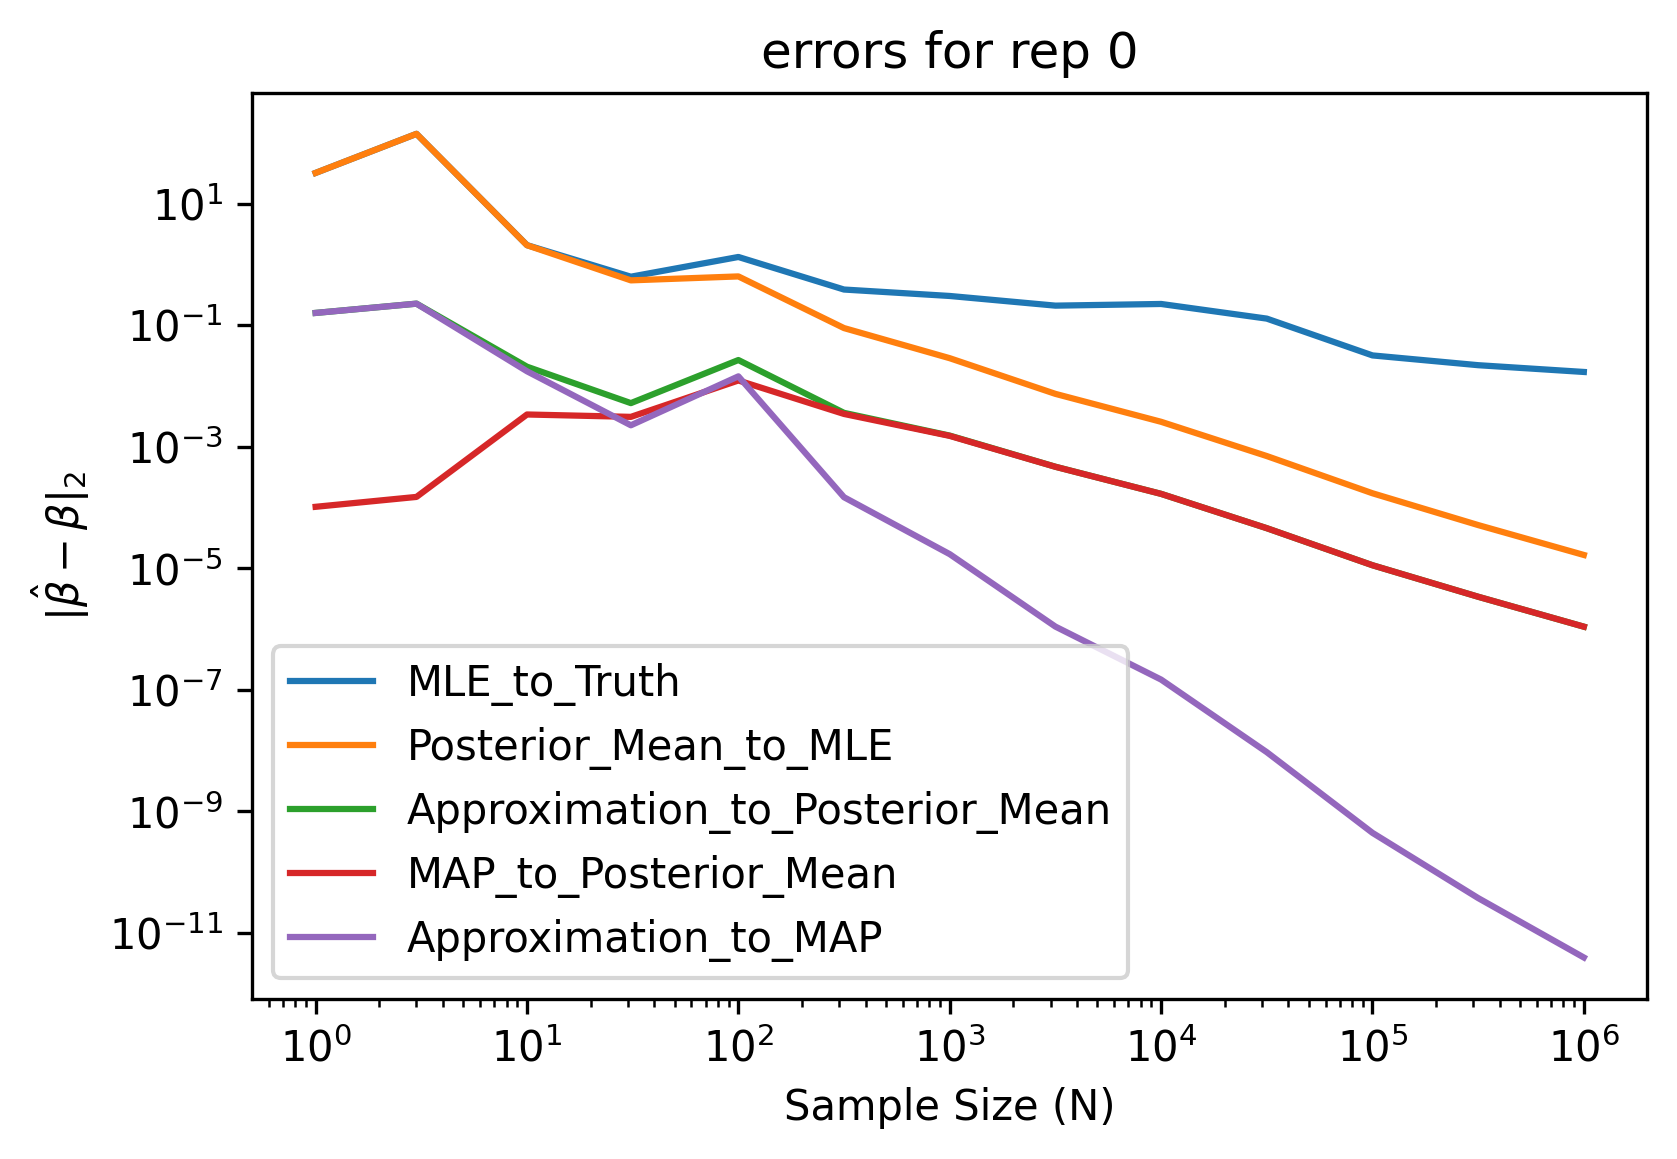

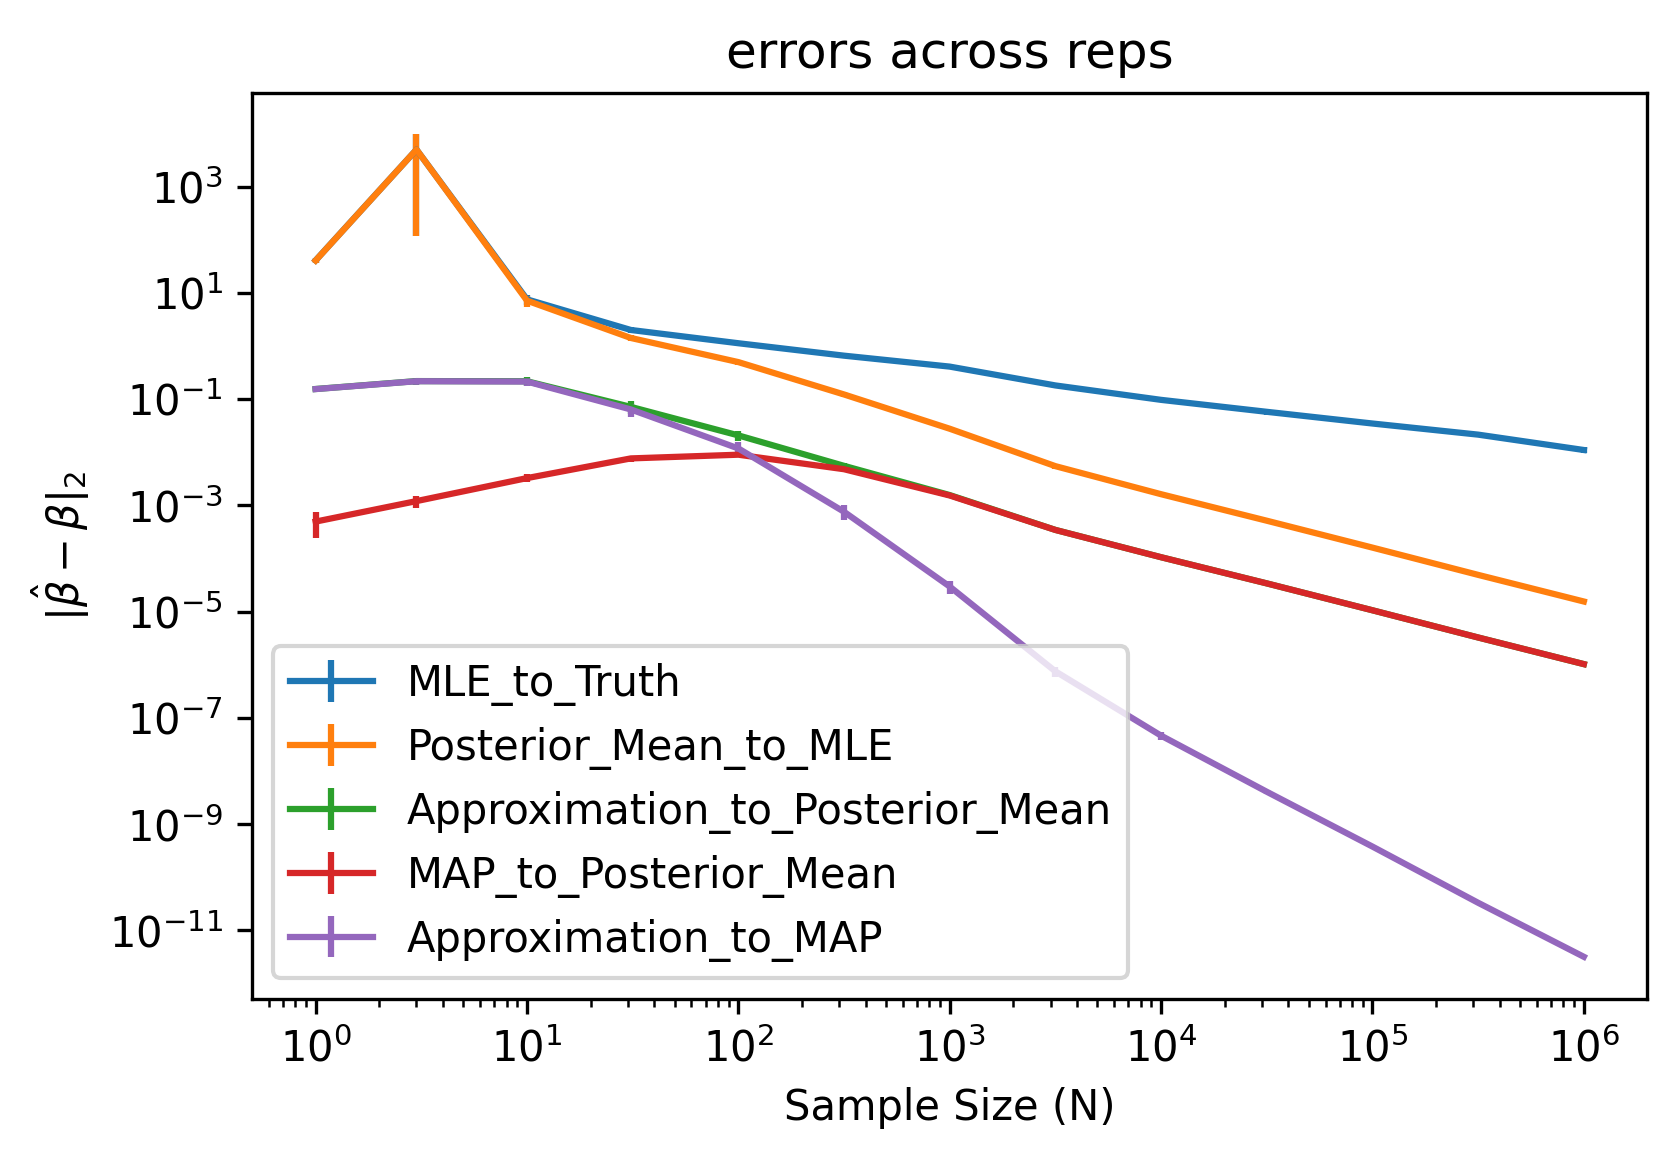

In [35]:
# collect for each method and some fixed beta the error for different sample sizes
max_order, n_reps = 7, 25
sigma_x = 0.25
n_grid_pts = 3

errors_by_pair_and_sample_size = simulate_and_compare(
    sigma_x=sigma_x, max_order=max_order, n_reps=n_reps, n_grid_pts=n_grid_pts, pts_per_order=2)
plot_rep(errors_by_pair_and_sample_size)
err_mean_and_sem_by_pair_and_sample_size = plot_mean_errs(errors_by_pair_and_sample_size)

In [36]:
col_label_pt1 = list(err_mean_and_sem_by_pair_and_sample_size.keys())
col_label_pt2 = list(err_mean_and_sem_by_pair_and_sample_size[col_label_pt1[0]].keys())
rows_labels = list(err_mean_and_sem_by_pair_and_sample_size[col_label_pt1[0]][col_label_pt2[0]].keys())
data = [[err_mean_and_sem_by_pair_and_sample_size[k1][k2][row] for row in rows_labels]
        for k1 in col_label_pt1
        for k2 in col_label_pt2
       ]
data = np.array(data).T
fn_out = "../results/logistic_regression/lr_approximation_errors.tsv"
with open(fn_out, 'w') as f:
    f.write("\t".join(["N"] + [k1 +"_"+ k2 for k1 in col_label_pt1 for k2 in col_label_pt2]) + "\n")
    for i, N in enumerate(rows_labels):
        f.write(str(N) + "\t" + "\t".join("%0.015f"%v for v in data[i])+"\n")